<a href="https://colab.research.google.com/github/kreshuklab/vem-primer-examples/blob/main/mitochondria/4_visualization_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # vEM-Mitochondria: Visualization and analysis
 
 Lorem ipsum

## Google Colab

IMPORTANT: Run the next cells until `Visualization` only if you execute this notebook on Google Colab. If you run this notebook locally, you need to set up a python environment with the correct dependencies beforehand, check out [these instructions](https://github.com/kreshuklab/vem-primer-examples#setting-up-conda-environments-advanced).

In [ ]:
# install additional dependencies
# note that this will automatically restart the session, you don't need to do anything despite some error messages that may be displayed
!pip install zarr

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")

## Visualization

Lorem ipsum

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import zarr

In [8]:
# RUN THIS IF YOU WORK LOCALLY
data_path = "vem-primer-data/MitoEM-H-predictions.ome.zarr"

In [3]:
# RUN THIS ON GOOGLE COLAB
data_path = "/content/gdrive/MyDrive/vem-primer-data/MitoEM-H-cropped.ome.zarr"

In [9]:
# TODO out of core
store = zarr.DirectoryStore(data_path)
with zarr.open(store, "r") as f:
    raw_volume = f["s0"][:]
    foreground = f["predictions/foreground"][:]
    boundaries = f["predictions/boundaries"][:]
    instance_seg = f["segmentation/instance_segmentation"][:]

PathNotFoundError: nothing found at path ''

In [ ]:
# IMPORTANT: Does not work on google colab
import napari
v = napari.Viewer()
v.add_image(raw_volume)
v.add_image(foreground)
v.add_image(boundaries)
v.add_image(instance_seg)

## Analysis

Lorem ipsum

In [4]:
# TODO use dask
seg_ids, sizes = np.unique(instance_seg, return_counts=True)
seg_ids, sizes = seg_ids[1:], sizes[1:]

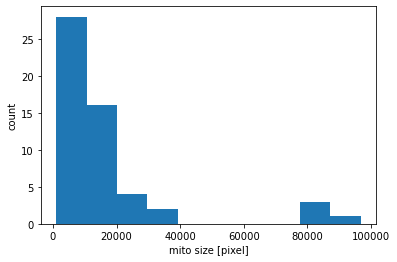

In [5]:
# histogram
# TODO biological criterion and axis labels
min_valid_size = 1000
analysed_sizes = sizes[sizes > min_valid_size]
plt.hist(analysed_sizes)
plt.xlabel("mito size [pixel]")
plt.ylabel("count")
plt.show()

### Display analysis results

In [6]:
z = 10  # this slice we display

# merge foreground and mito predictions diagonally
fgz, bdz = foreground[z], boundaries[z]
semantic = np.tril(fgz)
mask = semantic == 0
semantic[mask] = np.triu(bdz)[mask]
np.fill_diagonal(semantic, 1)

In [7]:
# map the size value to the seg id for the slice that we analyze
analysed_seg = np.zeros_like(instance_seg[z])
idsz = np.unique(instance_seg[z])
size_dict = {k: v for k, v in zip(seg_ids, sizes)}
size_dict[0] = 0
for sid in idsz:
    analysed_seg[instance_seg[z] == sid] = size_dict[sid]

In [8]:
# nice color map for an instance segmentation
def segmentation_cmap(seg):
    n = int(seg.max()) + 1
    vals = np.linspace(0, 1, n)
    np.random.shuffle(vals)
    cmap = plt.cm.Spectral(vals)
    cmap[0, :3] = 0
    return plt.cm.colors.ListedColormap(cmap)

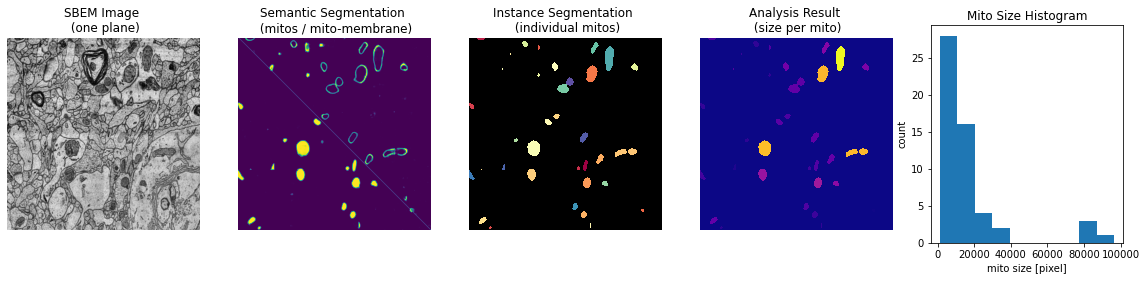

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(raw_volume[z], cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("SBEM Image \n (one plane)")

ax[1].imshow(semantic)
ax[1].axis("off")
ax[1].title.set_text("Semantic Segmentation \n (mitos / mito-membrane)")

ax[2].imshow(instance_seg[z], interpolation="nearest", cmap=segmentation_cmap(instance_seg[z]))
ax[2].axis("off")
ax[2].title.set_text("Instance Segmentation \n (individual mitos)")

a = ax[3].imshow(analysed_seg, interpolation="nearest", cmap="plasma")
ax[3].axis("off")
ax[3].title.set_text("Analysis Result \n (size per mito)")
# TODO work on positioning the colorbar
# https://stackoverflow.com/questions/13310594/positioning-the-colorbar
# fig.colorbar(a, ax=ax[3], shrink=0.7)

ax[4].hist(analysed_sizes)
ax[4].set_xlabel("mito size [pixel]")
ax[4].set_ylabel("count")
ax[4].title.set_text("Mito Size Histogram")

# plt.show()
plt.savefig("./mito-em-analysis.png", dpi=600)